In [1]:
import tensorflow as tf 
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import random, numpy as np, os
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.run_functions_eagerly(True)
def config_gpu(mp=False):
    print('Eager Model : ', tf.executing_eagerly())
    print('TensorFlow Cuda Built Test : ', tf.test.is_built_with_cuda)
    print('TensorFlow GPU Detected : ', tf.test.gpu_device_name())
    print('TensorFlow System Cuda Version : ', tf.sysconfig.get_build_info()["cuda_version"])
    print('TensorFlow System CudNN Version : ', tf.sysconfig.get_build_info()["cudnn_version"] )

    AUTO = tf.data.AUTOTUNE
    #GPUS = tf.config.list_physical_devices('GPU')
    GPUS = tf.config.experimental.list_physical_devices('GPU')
    if len(GPUS) > 0:
        tf.config.set_visible_devices(physical_devices[0:1], 'GPU')
    if GPUS:
        try:
            for GPU in GPUS:
                tf.config.experimental.set_memory_growth(GPU, True)
                logical_gpus = tf.config.list_logical_devices('GPU')
                print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
        except RuntimeError as  RE:
            print(RE)
    if mp:
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print('Mixed precision enabled')
        
#tf.keras.utils.set_random_seed(100)
config_gpu(mp=False)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Eager Model :  True
TensorFlow Cuda Built Test :  <function is_built_with_cuda at 0x000001B0B28155E0>
TensorFlow GPU Detected :  /device:GPU:0
TensorFlow System Cuda Version :  64_112
TensorFlow System CudNN Version :  64_8
2 Physical GPUs, 1 Logical GPUs
Physical devices cannot be modified after being initialized


# <a id='intro'>Plan</a>
#### [Wavelet with residual block](#the_destination)
#### [Efficient-net](#Efficient_net)
#### [Ensemblelearning](#Ensemble_learning)
#### [Metrics with Graph](#graph)
#### [Grad-CAM](#Gradcam)
#### [Result Metrics](#metrics)

# <a id=''>TF Dataset and Preprocess</a>

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from keras.layers import Lambda
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile

In [3]:
import os, cv2
import random, math
import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import tensorflow, keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_path = r'C:\Users\ADMIN\Documents\base_dir\train_dir'
#train_path = r'C:\Users\ADMIN\Documents\base_dir\train_dir_test'
test_path = r'C:\Users\ADMIN\Documents\base_dir\base_dir\val_dir'
batch_size = 16
train_batch_size = 4
#train_batch_size = 4
val_batch_size = 4
image_size = 224


In [5]:
def custom_augmentation(np_tensor):

  def random_contrast(np_tensor):
    return np.array(tf.image.random_contrast(np_tensor, 0.5, 2))

  def random_saturation(np_tensor):
    return np.array(tf.image.random_saturation(np_tensor, 0.2, 3))

  def random_crop(np_tensor):
    #cropped height between 70% to 130% of an original height
    new_height = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[0])
    #cropped width between 70% to 130% of an original width
    new_width = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[1])
    # resize to new height and width
    cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
    return np.array(tf.image.resize(cropped, np_tensor.shape[:2]))

  def gaussian_noise(np_tensor):
    mean = 0
    # variance: randomly between 1 to 25
    var = np.random.randint(1, 26)
    # sigma is square root of the variance value
    noise = np.random.normal(mean,var**0.5,np_tensor.shape)
    return np.clip(np_tensor + noise, 0, 255).astype('int')

  def cutout(np_tensor):
    cutout_height = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[0])
    cutout_width = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[1])
    cutout_height_point = np.random.randint(np_tensor.shape[0]-cutout_height)
    cutout_width_point = np.random.randint(np_tensor.shape[1]-cutout_width)
    np_tensor[cutout_height_point:cutout_height_point+cutout_height, cutout_width_point:cutout_width_point+cutout_width, :] = 127
    return np_tensor

  if (np.random.uniform() < 0.1):
    np_tensor = random_contrast(np_tensor)
  if (np.random.uniform() < 0.1):
    np_tensor = random_saturation(np_tensor)
  if (np.random.uniform() < 0.2):
    np_tensor = random_crop(np_tensor)
  if (np.random.uniform() < 0.2):
    np_tensor = gaussian_noise(np_tensor)
  if (np.random.uniform() < 0.3):
    np_tensor = cutout(np_tensor)
  return np.array(np_tensor)

In [6]:

datagen = ImageDataGenerator(#preprocessing_function=custom_augmentation,
                            rescale=1./255,
                             preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                            horizontal_flip = True,
                            vertical_flip=True
)
datagen1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                             rescale=1./255,)
                             #horizontal_flip = True,
                             #vertical_flip=True,)


train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size,)
                                           #subset='training')

valid_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,)

test_batches = datagen1.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=32,
                                            shuffle=False,)
                                          #subset='validation')
    

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


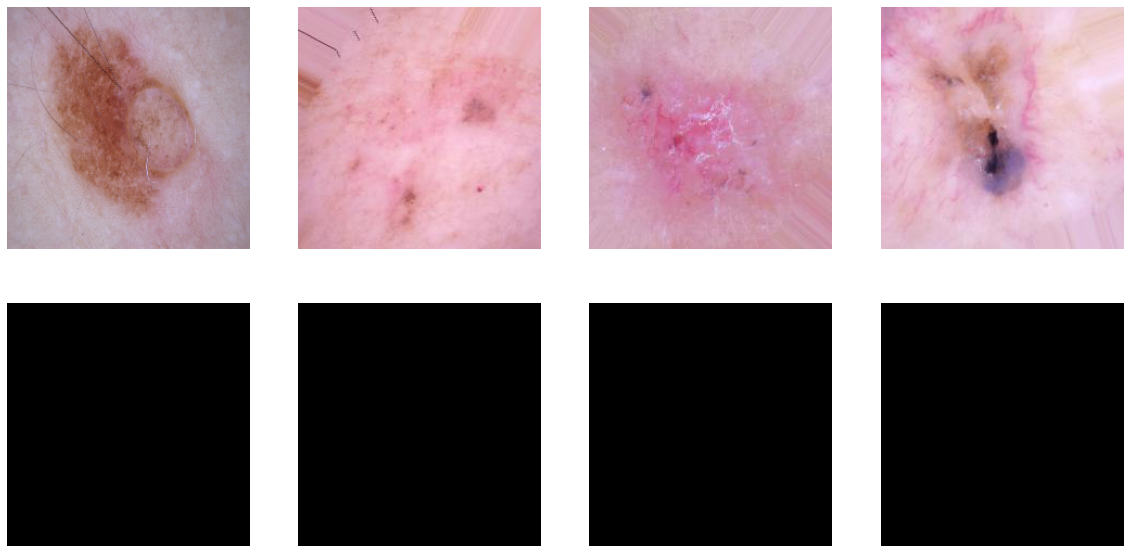

In [7]:
#densneet
%matplotlib inline
image, label = next(train_batches)
plt.figure(figsize=(20,10))
inline = 4
for i in range(inline):
    #print(image.size())
    plt.subplot(2, inline, i%inline +1)
    plt.axis('off')
    plt.imshow(image[i])
    #plt.title(f'Label: {label}')
    plt.subplot(2, inline, i%inline +5)
    plt.axis('off')
    plt.imshow(image[i].astype(np.uint8))

# Configuration

In [8]:
# Setting TPU as main device for training, if you get warnings while working with tpu's ignore them.

DEVICE = 'TPU'
if DEVICE == 'TPU':
    print('connecting to TPU...')
    try:        
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print('Could not connect to TPU')
        tpu = None

    if tpu:
        try:
            print('Initializing  TPU...')
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print('TPU initialized')
        except _:
            print('Failed to initialize TPU!')
    else:
        DEVICE = 'GPU'

if DEVICE != 'TPU':
    print('Using default strategy for CPU and single GPU')
    strategy = tf.distribute.get_strategy()

if DEVICE == 'GPU':
    print('Num GPUs Available: ',
          len(tf.config.experimental.list_physical_devices('GPU')))

print('REPLICAS: ', strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  2
REPLICAS:  1


In [9]:
cfg = dict(
           batch_size=4,
           img_size=384,
    
           lr_start=0.000005,
           lr_max=0.00000125,
           lr_min=0.000001,
           lr_rampup=5,
           lr_sustain=0,
           lr_decay=0.8,
           epochs=12,
    
           transform_prob=1.0,
           rot=180.0,
           shr=2.0,
           hzoom=8.0,
           wzoom=8.0,
           hshift=8.0,
           wshift=8.0,
    
           optimizer='adam',
           label_smooth_fac=0.05,
           tta_steps=20
            
        )

# <a id='the_destination'>Wavelet with residual block</a>
#### [Return Contents](#intro)

In [10]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [11]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2,decom_level_3,decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Fonction pour créer un bloc résiduel
def residual_block(x, filters, strides=(1, 1)):
    # Couches de convolution du bloc résiduel
    shortcut = x
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    # Connexion résiduelle
    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])
def get_wavelet_cnn_model():
    input_shape = 224, 224, 3

    input_ = Input(input_shape, name='the_input')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)

    # Adjust the number of channels in wavelet decomposition output
    input_l1 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l1')(input_l1)
    input_l2 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l2')(input_l2)
    input_l3 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l3')(input_l3)
    input_l4 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l4')(input_l4)

    # Architecture ResNet avec les blocs résiduels et les blocs de transformation en ondelettes

    x = input_
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)



    # Niveau 1
    x = input_l1
    relu_a = residual_block(x, filters=64, strides=(2, 2))
    #relu_a=ChannelAttention(128, 8)(relu_a)
    relu_a=SpatialAttention(10)(relu_a)

    # Niveau 2
    x = input_l2
    for _ in range(2):
        relu_1_2 = residual_block(x, filters=64)
    #relu_1_2=ChannelAttention(128, 8)(relu_1_2)
    relu_1_2=SpatialAttention(10)(relu_1_2)
      
    print("conc")
    concate_level_2 = concatenate([relu_1_2, relu_a])
    relu_2_2 = residual_block(concate_level_2, filters=128, strides=(2, 2))
    print(relu_2_2)
        
        
    x = input_l3
    relu_b_2 = residual_block(x, filters=64)
    for _ in range(2):
        relu_b_2 = residual_block(relu_b_2, filters=128)
    #relu_b_2=ChannelAttention(128, 8)(relu_b_2)
    relu_b_2=SpatialAttention(10)(relu_b_2)

    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    print("conc")
    print(concate_level_3)
    relu_3_2 = residual_block(concate_level_3, filters=256, strides=(2, 2))
    
    # Niveau 3
    x = input_l4
    relu_c_3 = residual_block(x, filters=64)
    for _ in range(2):
        relu_c_3 = residual_block(relu_c_3, filters=256)
    #relu_c_3=ChannelAttention(128, 8)(relu_c_3)
    relu_c_3=SpatialAttention(10)(relu_c_3)
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    print("conc")
    print(concate_level_4)
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 
    
    fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    norm_5 = BatchNormalization(name='norm_5')(fc_5)
    relu_5 = Activation('relu', name='relu_5')(norm_5)
    drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    fc_6 = Dense(2048, name='fc_6')(drop_5)
    norm_6 = BatchNormalization(name='norm_6')(fc_6)
    relu_6 = Activation('relu', name='relu_6')(norm_6)
    drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(7, activation='softmax', name='fc_7')(drop_6)
    
    model = Model(inputs=input_, outputs=output)

    return model

In [13]:
#wavelet model
wavelet = get_wavelet_cnn_model()

conc
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 128), dtype=tf.float32, name=None), name='activation_8/Relu:0', description="created by layer 'activation_8'")
conc
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 256), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")
conc
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")


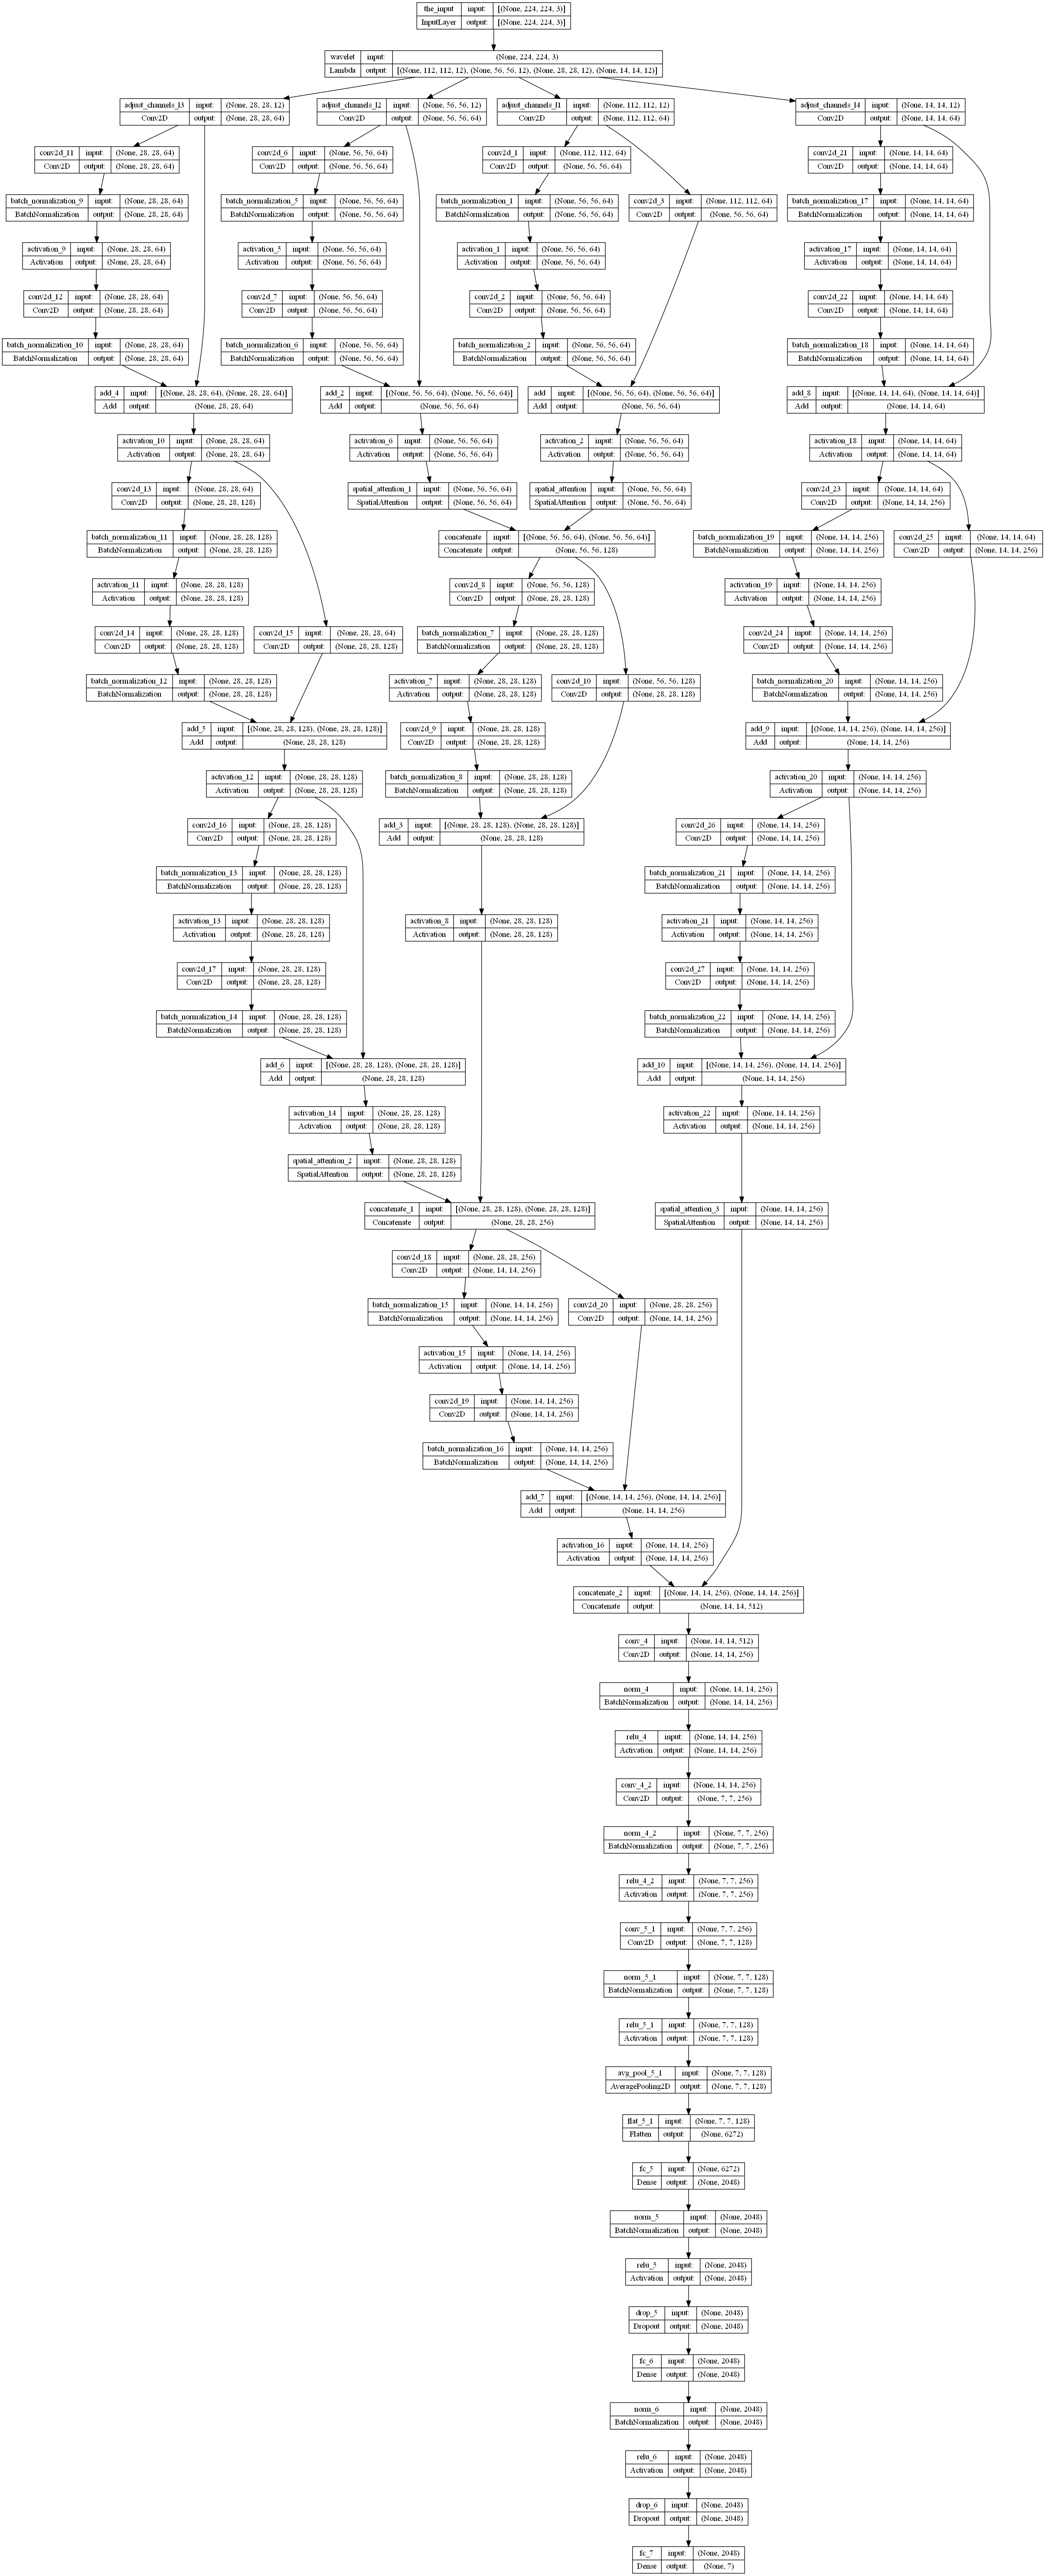

In [14]:
import tensorflow as tf 
display(tf.keras.utils.plot_model(wavelet, 
                                  show_shapes=True, 
                                  show_layer_names=True,
                                  expand_nested=True))

In [15]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

# Multi-Atrous Branch
class MultiAtrous(keras.Model):
    def __init__(self, 
                 dilation_rates=[6, 12, 18], 
                 upsampling=1, 
                 kernel_size=3, 
                 padding="same",  **kwargs):
        super(MultiAtrous, self).__init__(name='MultiAtrous', **kwargs)
        self.dilation_rates = dilation_rates
        self.kernel_size = kernel_size 
        self.upsampling = upsampling
        self.padding = padding
      
        # Dilated Convolutions                     
        self.dilated_convs = [
                              layers.Conv2D(
                                  filters       = int(1024 / 4), 
                                  kernel_size   = self.kernel_size,  
                                  padding       = self.padding, 
                                  dilation_rate = rate
                                ) for rate in self.dilation_rates
                             ]
        
        # Global Average Pooling Branch 
        self.gap_branch = keras.Sequential(
            [
                layers.GlobalAveragePooling2D(keepdims=True),
                layers.Conv2D(int(1024 / 2), kernel_size=1),
                layers.Activation('relu'),
                layers.UpSampling2D(size=self.upsampling, interpolation="bilinear")
            ] , name='gap_branch'
        )
        
    def call(self, inputs, training=None, **kwargs):
        local_feature = []
        for dilated_conv in self.dilated_convs:
            x = dilated_conv(inputs) 
            x = self.gap_branch(x)
            local_feature.append(x)
        return tf.concat(local_feature, axis=-1)

    def get_config(self):
        config = {
            'dilation_rates': self.dilation_rates,
            'kernel_size'   : self.kernel_size,
            'padding'       : self.padding,
            'upsampling'    : self.upsampling
        }
        base_config = super(MultiAtrous, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [16]:
class GeneralizedMeanPooling2D(layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, epsilon=1e-6, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize
        self.epsilon   = epsilon
        super(GeneralizedMeanPooling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.p = self.add_weight(name="norms", 
                                 shape=(input_shape[-1],),
                                 initializer=keras.initializers.constant(self.init_norm),
                                 trainable=True)
        super(GeneralizedMeanPooling2D, self).build(input_shape)

    def call(self, inputs):
        x = tf.abs(tf.maximum(self.epsilon, inputs))
        x = tf.pow(x, self.p)
        x = tf.reduce_mean(x, axis=[1,2], keepdims=False) 
        x = tf.pow(x, (1.0 / self.p))
        if self.normalize:
            x = tf.nn.l2_normalize(x, 1)
        return x

    def get_config(self):
        config = {
            'init_norm' : self.init_norm,
            'normalize' : self.normalize,
            'epsilon'   : self.epsilon
        }
        base_config = super(GeneralizedMeanPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [17]:
class SkinNet(keras.Model):
    def __init__(self, backbone=None, num_classes=1, activation=None, **kwargs):
        super(SkinNet, self).__init__(name='SkinNet', **kwargs)
        # Number of classes 
        self.num_classes = num_classes
        self.activation  = activation
        
        # Base blcoks 
        self.base = backbone
        self.base_input_shape  = self.base.input_shape[0][1]

        self.glob_branch_pool = keras.Sequential(
            [
                GeneralizedMeanPooling2D(),
                layers.Dense(1024, activation=None)
            ], 
            name='GlobalBranchPooling'
        )
        
        # Head block
        self.classifier = keras.Sequential(
            [
                #layers.GlobalAveragePooling2D(name='HeadGAP'),
                layers.Dense(self.num_classes, activation = self.activation)
            ], 
            name='Classifiers'
        )
       
    # forwarding the computation 
    def call(self, inputs, training=None, **kwargs):
        # Get tensor from target layers 
        to_global= self.base(inputs)

        # Pass the received tensor to Top building blocks 
        global_feat    = self.glob_branch_pool(to_global)
        return self.classifier(global_feat)
    """
    def train_step(self, data):
        return train_step_sam(self, data, rho=0.05)
    """

    def build_graph(self):
        x = keras.Input(shape=(self.base_input_shape, self.base_input_shape, 3))
        return keras.Model(inputs=[x], outputs=self.call(x))

In [18]:
from tensorflow.keras import applications, layers, Model, Input

for l in wavelet.layers:
    print(l.name, l.output_shape)  

the_input [(None, 224, 224, 3)]
wavelet [(None, 112, 112, 12), (None, 56, 56, 12), (None, 28, 28, 12), (None, 14, 14, 12)]
adjust_channels_l3 (None, 28, 28, 64)
conv2d_11 (None, 28, 28, 64)
batch_normalization_9 (None, 28, 28, 64)
activation_9 (None, 28, 28, 64)
conv2d_12 (None, 28, 28, 64)
batch_normalization_10 (None, 28, 28, 64)
adjust_channels_l2 (None, 56, 56, 64)
adjust_channels_l1 (None, 112, 112, 64)
add_4 (None, 28, 28, 64)
conv2d_6 (None, 56, 56, 64)
conv2d_1 (None, 56, 56, 64)
activation_10 (None, 28, 28, 64)
batch_normalization_5 (None, 56, 56, 64)
batch_normalization_1 (None, 56, 56, 64)
conv2d_13 (None, 28, 28, 128)
adjust_channels_l4 (None, 14, 14, 64)
activation_5 (None, 56, 56, 64)
activation_1 (None, 56, 56, 64)
batch_normalization_11 (None, 28, 28, 128)
conv2d_21 (None, 14, 14, 64)
conv2d_7 (None, 56, 56, 64)
conv2d_2 (None, 56, 56, 64)
activation_11 (None, 28, 28, 128)
batch_normalization_17 (None, 14, 14, 64)
batch_normalization_6 (None, 56, 56, 64)
batch_normaliza

In [19]:
#9bel mnni kente dayra wavelet 3adi bla residual block kent dayra ghir model.input ms 3tatni error 'nonetype' dkchi 3lash
#beddeltha b hadi model.inputs
new_base = keras.Model(
    [wavelet.inputs], 
    [
        wavelet.get_layer('relu_4').output # for global branch (None, 14, 14, 256)
    ], 
    name='Wavelet'
)

In [20]:
skin_net = SkinNet(new_base, num_classes=7, activation='softmax')
skin_net.build_graph().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Wavelet (Functional)        (None, 14, 14, 256)       5512256   
                                                                 
 GlobalBranchPooling (Sequen  (None, 1024)             263424    
 tial)                                                           
                                                                 
 Classifiers (Sequential)    (None, 7)                 7175      
                                                                 
Total params: 5,782,855
Trainable params: 5,776,711
Non-trainable params: 6,144
_________________________________________________________________


In [21]:
#focal loss

In [22]:
tf.config.optimizer.set_jit(True)
def compileNewModel():
    
    ''' Configuring the model with losses and metrics. '''    
    
    with strategy.scope():
        model = skin_net

    with strategy.scope():
        model.compile(optimizer='sgd', loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        #tf.keras.metrics.AUC(name='auc')
    return model

def getLearnRateCallback(cfg):
    
    ''' Using callbacks for learning rate adjustments. '''
    
    lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * strategy.num_replicas_in_sync * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback


def learnModel(model, ds_train, cfg, ds_val):
    
    ''' Fitting things together for training '''
    
    filepath1 = "Skin_attent_weights_acc_att_wave_14_test.h5"
    checkpoint = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
    callbacks = [getLearnRateCallback(cfg), checkpoint]

    history = model.fit(ds_train,
                        validation_data=ds_val,
                        verbose=True,
                        epochs=400,
                        callbacks=callbacks)

    return history

model = compileNewModel()
history = learnModel(model, train_batches, cfg, valid_batches)

In [23]:
model = compileNewModel()
history = learnModel(model, train_batches, cfg, valid_batches)

Epoch 1/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.9037 - accuracy: 0.2402
Epoch 1: val_accuracy improved from -inf to 0.69403, saving model to Skin_attent_weights_acc_att_wave_14_test.h5
9643/9643 [==============================] - 665s 67ms/step - loss: 1.9037 - accuracy: 0.2402 - val_loss: 1.4332 - val_accuracy: 0.6940 - lr: 5.0000e-06
Epoch 2/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.7805 - accuracy: 0.3188
Epoch 2: val_accuracy did not improve from 0.69403
9643/9643 [==============================] - 661s 68ms/step - loss: 1.7805 - accuracy: 0.3187 - val_loss: 1.2325 - val_accuracy: 0.6887 - lr: 5.0000e-06
Epoch 3/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.7244 - accuracy: 0.3394
Epoch 3: val_accuracy did not improve from 0.69403
9643/9643 [==============================] - 670s 70ms/step - loss: 1.7243 - accuracy: 0.3394 - val_loss: 1.1345 - val_accuracy: 0.6748 - lr: 5.0000e-06
Epoch 4/400
9642/9643 [======

Epoch 27/400
9643/9643 [==============================] - ETA: 0s - loss: 1.4633 - accuracy: 0.4434
Epoch 27: val_accuracy did not improve from 0.74094
9643/9643 [==============================] - 660s 68ms/step - loss: 1.4633 - accuracy: 0.4434 - val_loss: 0.8224 - val_accuracy: 0.7271 - lr: 1.0369e-06
Epoch 28/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.4642 - accuracy: 0.4404
Epoch 28: val_accuracy did not improve from 0.74094
9643/9643 [==============================] - 661s 69ms/step - loss: 1.4642 - accuracy: 0.4405 - val_loss: 0.8262 - val_accuracy: 0.7313 - lr: 1.0295e-06
Epoch 29/400
9643/9643 [==============================] - ETA: 0s - loss: 1.4585 - accuracy: 0.4453
Epoch 29: val_accuracy did not improve from 0.74094
9643/9643 [==============================] - 651s 67ms/step - loss: 1.4585 - accuracy: 0.4453 - val_loss: 0.8028 - val_accuracy: 0.7345 - lr: 1.0236e-06
Epoch 30/400
9643/9643 [==============================] - ETA: 0s - loss: 1.4611 - ac

Epoch 53/400
9641/9643 [============================>.] - ETA: 0s - loss: 1.4060 - accuracy: 0.4636
Epoch 53: val_accuracy improved from 0.75480 to 0.75586, saving model to Skin_attent_weights_acc_att_wave_14_test.h5
9643/9643 [==============================] - 666s 69ms/step - loss: 1.4060 - accuracy: 0.4636 - val_loss: 0.7862 - val_accuracy: 0.7559 - lr: 1.0001e-06
Epoch 54/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.4022 - accuracy: 0.4674
Epoch 54: val_accuracy did not improve from 0.75586
9643/9643 [==============================] - 666s 69ms/step - loss: 1.4022 - accuracy: 0.4674 - val_loss: 0.8148 - val_accuracy: 0.7420 - lr: 1.0001e-06
Epoch 55/400
9643/9643 [==============================] - ETA: 0s - loss: 1.3997 - accuracy: 0.4685
Epoch 55: val_accuracy did not improve from 0.75586
9643/9643 [==============================] - 668s 69ms/step - loss: 1.3997 - accuracy: 0.4685 - val_loss: 0.7930 - val_accuracy: 0.7431 - lr: 1.0001e-06
Epoch 56/400
9643/96

9642/9643 [============================>.] - ETA: 0s - loss: 1.3508 - accuracy: 0.4891
Epoch 79: val_accuracy improved from 0.76866 to 0.76972, saving model to Skin_attent_weights_acc_att_wave_14_test.h5
9643/9643 [==============================] - 658s 68ms/step - loss: 1.3508 - accuracy: 0.4892 - val_loss: 0.7302 - val_accuracy: 0.7697 - lr: 1.0000e-06
Epoch 80/400
9643/9643 [==============================] - ETA: 0s - loss: 1.3502 - accuracy: 0.4874
Epoch 80: val_accuracy did not improve from 0.76972
9643/9643 [==============================] - 669s 69ms/step - loss: 1.3502 - accuracy: 0.4874 - val_loss: 0.7121 - val_accuracy: 0.7633 - lr: 1.0000e-06
Epoch 81/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.3503 - accuracy: 0.4858
Epoch 81: val_accuracy did not improve from 0.76972
9643/9643 [==============================] - 668s 69ms/step - loss: 1.3503 - accuracy: 0.4858 - val_loss: 0.7256 - val_accuracy: 0.7644 - lr: 1.0000e-06
Epoch 82/400
9642/9643 [=========

Epoch 131/400
9643/9643 [==============================] - ETA: 0s - loss: 1.2837 - accuracy: 0.5091
Epoch 131: val_accuracy did not improve from 0.78465
9643/9643 [==============================] - 677s 70ms/step - loss: 1.2837 - accuracy: 0.5091 - val_loss: 0.6597 - val_accuracy: 0.7719 - lr: 1.0000e-06
Epoch 132/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.2796 - accuracy: 0.5116
Epoch 132: val_accuracy did not improve from 0.78465
9643/9643 [==============================] - 680s 70ms/step - loss: 1.2796 - accuracy: 0.5116 - val_loss: 0.6630 - val_accuracy: 0.7772 - lr: 1.0000e-06
Epoch 133/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.2789 - accuracy: 0.5119
Epoch 133: val_accuracy did not improve from 0.78465
9643/9643 [==============================] - 683s 71ms/step - loss: 1.2790 - accuracy: 0.5118 - val_loss: 0.6506 - val_accuracy: 0.7814 - lr: 1.0000e-06
Epoch 134/400
9643/9643 [==============================] - ETA: 0s - loss: 1.27

9643/9643 [==============================] - 684s 71ms/step - loss: 1.2555 - accuracy: 0.5202 - val_loss: 0.6216 - val_accuracy: 0.7825 - lr: 1.0000e-06
Epoch 158/400
9643/9643 [==============================] - ETA: 0s - loss: 1.2556 - accuracy: 0.5197
Epoch 158: val_accuracy did not improve from 0.78891
9643/9643 [==============================] - 708s 73ms/step - loss: 1.2556 - accuracy: 0.5197 - val_loss: 0.6311 - val_accuracy: 0.7846 - lr: 1.0000e-06
Epoch 159/400
9643/9643 [==============================] - ETA: 0s - loss: 1.2586 - accuracy: 0.5198
Epoch 159: val_accuracy did not improve from 0.78891
9643/9643 [==============================] - 683s 71ms/step - loss: 1.2586 - accuracy: 0.5198 - val_loss: 0.6143 - val_accuracy: 0.7836 - lr: 1.0000e-06
Epoch 160/400
9643/9643 [==============================] - ETA: 0s - loss: 1.2522 - accuracy: 0.5233
Epoch 160: val_accuracy did not improve from 0.78891
9643/9643 [==============================] - 709s 74ms/step - loss: 1.2522 - ac

Epoch 184/400
9643/9643 [==============================] - ETA: 0s - loss: 1.2273 - accuracy: 0.5331
Epoch 184: val_accuracy did not improve from 0.79851
9643/9643 [==============================] - 701s 73ms/step - loss: 1.2273 - accuracy: 0.5331 - val_loss: 0.6002 - val_accuracy: 0.7974 - lr: 1.0000e-06
Epoch 185/400
9643/9643 [==============================] - ETA: 0s - loss: 1.2285 - accuracy: 0.5307
Epoch 185: val_accuracy did not improve from 0.79851
9643/9643 [==============================] - 698s 72ms/step - loss: 1.2285 - accuracy: 0.5307 - val_loss: 0.5995 - val_accuracy: 0.7974 - lr: 1.0000e-06
Epoch 186/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.2255 - accuracy: 0.5303
Epoch 186: val_accuracy did not improve from 0.79851
9643/9643 [==============================] - 697s 72ms/step - loss: 1.2255 - accuracy: 0.5303 - val_loss: 0.6108 - val_accuracy: 0.7846 - lr: 1.0000e-06
Epoch 187/400
9643/9643 [==============================] - ETA: 0s - loss: 1.22

9643/9643 [==============================] - ETA: 0s - loss: 1.1749 - accuracy: 0.5540
Epoch 236: val_accuracy did not improve from 0.81343
9643/9643 [==============================] - 705s 73ms/step - loss: 1.1749 - accuracy: 0.5540 - val_loss: 0.5663 - val_accuracy: 0.8017 - lr: 1.0000e-06
Epoch 237/400
9643/9643 [==============================] - ETA: 0s - loss: 1.1789 - accuracy: 0.5504
Epoch 237: val_accuracy did not improve from 0.81343
9643/9643 [==============================] - 717s 74ms/step - loss: 1.1789 - accuracy: 0.5504 - val_loss: 0.5721 - val_accuracy: 0.8081 - lr: 1.0000e-06
Epoch 238/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.1795 - accuracy: 0.5468
Epoch 238: val_accuracy did not improve from 0.81343
9643/9643 [==============================] - 688s 71ms/step - loss: 1.1795 - accuracy: 0.5469 - val_loss: 0.5599 - val_accuracy: 0.8081 - lr: 1.0000e-06
Epoch 239/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.1777 - accuracy:

Epoch 263/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.1579 - accuracy: 0.5586
Epoch 263: val_accuracy did not improve from 0.82196
9643/9643 [==============================] - 720s 75ms/step - loss: 1.1579 - accuracy: 0.5586 - val_loss: 0.5338 - val_accuracy: 0.8134 - lr: 1.0000e-06
Epoch 264/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.1572 - accuracy: 0.5577
Epoch 264: val_accuracy did not improve from 0.82196
9643/9643 [==============================] - 685s 71ms/step - loss: 1.1573 - accuracy: 0.5577 - val_loss: 0.5470 - val_accuracy: 0.8113 - lr: 1.0000e-06
Epoch 265/400
9643/9643 [==============================] - ETA: 0s - loss: 1.1583 - accuracy: 0.5568
Epoch 265: val_accuracy did not improve from 0.82196
9643/9643 [==============================] - 686s 71ms/step - loss: 1.1583 - accuracy: 0.5568 - val_loss: 0.5424 - val_accuracy: 0.8177 - lr: 1.0000e-06
Epoch 266/400
9641/9643 [============================>.] - ETA: 0s - loss: 1.15

9643/9643 [==============================] - 714s 74ms/step - loss: 1.1365 - accuracy: 0.5665 - val_loss: 0.5295 - val_accuracy: 0.8156 - lr: 1.0000e-06
Epoch 290/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.1381 - accuracy: 0.5656
Epoch 290: val_accuracy did not improve from 0.82623
9643/9643 [==============================] - 723s 75ms/step - loss: 1.1381 - accuracy: 0.5656 - val_loss: 0.5448 - val_accuracy: 0.8166 - lr: 1.0000e-06
Epoch 291/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.1376 - accuracy: 0.5655
Epoch 291: val_accuracy did not improve from 0.82623
9643/9643 [==============================] - 719s 75ms/step - loss: 1.1376 - accuracy: 0.5655 - val_loss: 0.5255 - val_accuracy: 0.8220 - lr: 1.0000e-06
Epoch 292/400
9643/9643 [==============================] - ETA: 0s - loss: 1.1328 - accuracy: 0.5686
Epoch 292: val_accuracy did not improve from 0.82623
9643/9643 [==============================] - 718s 74ms/step - loss: 1.1328 - ac

Epoch 343/400
9643/9643 [==============================] - ETA: 0s - loss: 1.0985 - accuracy: 0.5805
Epoch 343: val_accuracy did not improve from 0.82942
9643/9643 [==============================] - 736s 76ms/step - loss: 1.0985 - accuracy: 0.5805 - val_loss: 0.5162 - val_accuracy: 0.8209 - lr: 1.0000e-06
Epoch 344/400
9643/9643 [==============================] - ETA: 0s - loss: 1.0957 - accuracy: 0.5817
Epoch 344: val_accuracy did not improve from 0.82942
9643/9643 [==============================] - 731s 76ms/step - loss: 1.0957 - accuracy: 0.5817 - val_loss: 0.5154 - val_accuracy: 0.8188 - lr: 1.0000e-06
Epoch 345/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.0955 - accuracy: 0.5798
Epoch 345: val_accuracy did not improve from 0.82942
9643/9643 [==============================] - 738s 77ms/step - loss: 1.0955 - accuracy: 0.5798 - val_loss: 0.5220 - val_accuracy: 0.8198 - lr: 1.0000e-06
Epoch 346/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.09

Epoch 370/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.0738 - accuracy: 0.5909
Epoch 370: val_accuracy did not improve from 0.82942
9643/9643 [==============================] - 756s 78ms/step - loss: 1.0738 - accuracy: 0.5909 - val_loss: 0.5013 - val_accuracy: 0.8241 - lr: 1.0000e-06
Epoch 371/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.0750 - accuracy: 0.5900
Epoch 371: val_accuracy improved from 0.82942 to 0.83156, saving model to Skin_attent_weights_acc_att_wave_14_test.h5
9643/9643 [==============================] - 743s 77ms/step - loss: 1.0749 - accuracy: 0.5900 - val_loss: 0.5092 - val_accuracy: 0.8316 - lr: 1.0000e-06
Epoch 372/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.0760 - accuracy: 0.5897
Epoch 372: val_accuracy did not improve from 0.83156
9643/9643 [==============================] - 759s 79ms/step - loss: 1.0760 - accuracy: 0.5897 - val_loss: 0.5117 - val_accuracy: 0.8220 - lr: 1.0000e-06
Epoch 373/400


9643/9643 [==============================] - 753s 78ms/step - loss: 1.0578 - accuracy: 0.5985 - val_loss: 0.5041 - val_accuracy: 0.8230 - lr: 1.0000e-06
Epoch 397/400
9643/9643 [==============================] - ETA: 0s - loss: 1.0585 - accuracy: 0.5962
Epoch 397: val_accuracy did not improve from 0.83156
9643/9643 [==============================] - 752s 78ms/step - loss: 1.0585 - accuracy: 0.5962 - val_loss: 0.5055 - val_accuracy: 0.8252 - lr: 1.0000e-06
Epoch 398/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.0580 - accuracy: 0.5958
Epoch 398: val_accuracy did not improve from 0.83156
9643/9643 [==============================] - 750s 78ms/step - loss: 1.0580 - accuracy: 0.5958 - val_loss: 0.5004 - val_accuracy: 0.8252 - lr: 1.0000e-06
Epoch 399/400
9642/9643 [============================>.] - ETA: 0s - loss: 1.0575 - accuracy: 0.5969
Epoch 399: val_accuracy did not improve from 0.83156
9643/9643 [==============================] - 755s 78ms/step - loss: 1.0576 - ac

In [24]:
#dolg_net.load_weights('Skin_attent_weights_acc_att_wave_14_test.h5')

In [25]:
#dolg_net.save_weights('Skin_attent_weights_acc_att_wave_14_test.h5')

# <a id='Efficient_net'>Efficient-net</a>
#### [Return Contents](#intro)

In [26]:
#! /opt/conda/bin/python3.7 -m pip install -q --upgrade pip
#! pip install -q efficientnet

In [27]:
import efficientnet.tfkeras as efn

In [28]:
def get_model():
    
    ''' This function gets the layers inclunding efficientnet ones. '''
    
    model_input = tf.keras.Input(shape=(224,224, 3),
                                 name='img_input')

    dummy = tf.keras.layers.Lambda(lambda x: x)(model_input)



    x = efn.EfficientNetB7(include_top=False,
                           weights='noisy-student',
                           input_shape=(224,224, 3),
                           pooling='avg')(dummy)
    x = tf.keras.layers.Dense(7, activation='softmax')(x)
    
    """
    x = efn.EfficientNetB4(include_top=False,
                           weights='noisy-student',
                           input_shape=(224,224, 3),
                           pooling='avg')(dummy)
    x = tf.keras.layers.Dense(7, activation='softmax')(x)
    outputs.append(x)
    """
    """
    x = efn.EfficientNetB5(include_top=False,
                           weights='noisy-student',
                           input_shape=(224,224, 3),
                           pooling='avg')(dummy)
    x = tf.keras.layers.Dense(7, activation='softmax')(x)
    outputs.append(x)
    """

    model = tf.keras.Model(model_input, x, name='aNetwork')
    model.summary()
    return model

In [29]:
with strategy.scope():
    base = efn.EfficientNetB7(include_top=False,
                               weights='noisy-student',
                               input_shape=(224,224, 3),
                               pooling='avg', classes=7)
    

In [30]:
with strategy.scope():
    efficient = get_model()

Model: "aNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 efficientnet-b7 (Functional  (None, 2560)             64097680  
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 7)                 17927     
                                                                 
Total params: 64,115,607
Trainable params: 63,804,887
Non-trainable params: 310,720
_________________________________________________________________


In [31]:
def compileNewModel():
    
    ''' Configuring the model with losses and metrics. '''    
    
    with strategy.scope():
        model = efficient

    with strategy.scope():
        model.compile(optimizer='sgd', loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        #tf.keras.metrics.AUC(name='auc')
    return model

def getLearnRateCallback(cfg):
    
    ''' Using callbacks for learning rate adjustments. '''
    
    lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * strategy.num_replicas_in_sync * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback


def learnModel(model, ds_train, cfg, ds_val):
    
    ''' Fitting things together for training '''
    
    filepath1 = "Efficient_att_ens.h5"
    checkpoint = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
    callbacks = [getLearnRateCallback(cfg), checkpoint]

    history = model.fit(ds_train,
                        validation_data=ds_val,
                        verbose=True,
                        epochs=100,
                        callbacks=callbacks)

    return history

In [32]:
#efficient net bou7dou i have to save it tooo.. # hada wavelet with global dolg i have to save it (la 2eme fois je dois uploader les meilleurs poids avant enregistremnt)
model1 = compileNewModel()
history1 = learnModel(model1, train_batches, cfg, valid_batches)

Epoch 1/400


UnknownError: Graph execution error:

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.8 = (f32[4,160,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3840,1,1]{3,2,1,0} %bitcast.22, f32[1,1,3840,160]{1,0,2,3} %copy.8, f32[160]{0} %arg4.5), window={size=1x1}, dim_labels=bf01_01io->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="aNetwork/efficientnet-b7/block7b_se_reduce/Conv2D"}, backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16779776 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node cluster_7_1/xla_compile}}]] [Op:__inference_train_function_15903761]

In [ ]:
model1.load_weights('Efficient_att_ens.h5')

# <a id='Ensemble_learning'>Ensemble learning</a>
#### [Return Contents](#intro)

In [ ]:
from sklearn.utils import class_weight
#y_train_w = np.array(y_train)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [ ]:
model_input = keras.Input((224,224,3))
def ensemble(models, model_input):
    outputs = [model(model_input) for model in models]
    y = keras.layers.Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model
def compileNewModel():
    
    ''' Configuring the model with losses and metrics. '''    
    
    with strategy.scope():
        model = ensemble([wavelet, efficient], model_input)

    with strategy.scope():
        model.compile(optimizer='sgd', loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        #tf.keras.metrics.AUC(name='auc')
    return model

def getLearnRateCallback(cfg):
    
    ''' Using callbacks for learning rate adjustments. '''
    
    lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * strategy.num_replicas_in_sync * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback


def learnModel(model, ds_train, cfg, ds_val):
    
    ''' Fitting things together for training '''
    
    filepath1 = "Ensemble_att_ens.h5"
    checkpoint = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
    callbacks = [getLearnRateCallback(cfg), checkpoint]

    history = model.fit(ds_train,
                        validation_data=ds_val,
                        verbose=True,
                        epochs=100,
                        callbacks=callbacks)

    return history

In [ ]:
model2 = compileNewModel()
history2 = learnModel(model2, train_batches, cfg, valid_batches)

In [ ]:
#model2.load_weights('Ensemble_att_ens.h5')
#model2.save('Ensemble_att_ens_best.model')

# <a id='graph'>Metrics with Graph</a>
#### [Return Contents](#intro)

In [ ]:
#model.load_weights('Dolg_net_att_ens.h5')
dolg_net.load_weights('Dolg_net_att_ens.h5')

In [ ]:
#model.save_weights('Dolg_net_att_ens_best_model.h5')
dolg_net.save_weights('Dolg_net_att_ens_best.h5')

In [ ]:
model1.load_weights('Efficient_att_ens.h5')
#efficient.load_weights('Efficient_att_ens.h5')

In [ ]:
#model1.save('Efficientnet_best_mo.h5')
efficient.save('Efficientnet_best.h5')

In [ ]:
#model2.load_weights('Ensemble_att_ens.h5')
model2.save('Ensemble_att_ens_best.model')

In [ ]:
import seaborn as sns
def plot_training_curves(history, ):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();

In [ ]:
def info_layers(model ):
    # вывод информации по слоям модели в процессе тюнинга
    
    print("Number of layers in the model:", len(model.layers))
    print("Number of trainable_variables layers in the model:", len(model.trainable_variables))
    #print("Number of layers in the base model: ", len(base_model.layers))
    #print("Number of variables layers in the base model: ", len(base_model.trainable_variables))
    #print("Layers in the model:")
    #for layer in model.layers:
     #   print(layer, layer.trainable)

def graph(history):
    # построние графиков изменения метрики и функции потерь в процессе обучения по эпохам
    
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], 'b*-', label="training acc")
    plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
    plt.grid()
    plt.title("train_acc vs val_acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], 'b*-', label="training loss")
    plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
    plt.grid()
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

In [ ]:
plot_training_curves(history)

In [ ]:
graph(history)

In [ ]:
plot_training_curves(history1)

In [ ]:
graph(history1)

In [ ]:
plot_training_curves(history2)

In [ ]:
graph(history2)

In [ ]:
print(info_layers(model))
print('---------------------------------------------------------------------------------------')
print(info_layers(dolg_net.layers[0]))
print('---------------------------------------------------------------------------------------')
print(info_layers(dolg_net))

In [ ]:
print(info_layers(model1))
print('---------------------------------------------------------------------------------------')
print(info_layers(model1.layers[2]))

model2.summary()

In [ ]:
print(info_layers(model2))
print('---------------------------------------------------------------------------------------')
print(info_layers(model2.layers[1]))
print('---------------------------------------------------------------------------------------')
print(info_layers(model2.layers[2]))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



# argmax returns the index of the max value in a row bl weights ou transfer learning bla augmentation
#cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

In [ ]:
def metrics(model):  
    predictions = model.predict(test_batches, steps=len(test_batches), verbose=0)
    #geting predictions on test dataset
    y_pred = np.argmax(predictions, axis=1)
    targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    #getting the true labels per image 
    y_true = test_batches.classes
    #getting the predicted labels per image 
    y_prob=predictions
    from tensorflow.keras.utils import to_categorical
    y_test = to_categorical(y_true)

    # Creating classification report 
    report = classification_report(y_true, y_pred, target_names=targetnames)

    print("Classification Report:")
    print(report)

    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))
    
    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    tpr={}
    fpr={}
    roc_auc={}
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print("Micro Roc score: " + str(roc_auc["micro"]))

    print('---------------------------------------------------------------------------------------')
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(7):
        r = roc_auc_score(y_test[:, i], y_prob[:, i])
        print("The ROC AUC score of "+targetnames[i]+" is:" +str(r))

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = dict()
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
    plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
    plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
    plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
    plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of %s'%targetnames[i])
    plt.legend(loc="lower right")
    plt.show()
    return predictions

In [ ]:
import itertools
test_labels = test_batches.classes
# argmax returns the index of the max value in a row bl weights ou transfer learning bla augmentation
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels,normalize=True, title='Confusion Matrix')

In [ ]:
predictions = metrics(model1)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
from  matplotlib import pyplot as plt
import numpy as np
from numpy import expand_dims
file_path= r"D:\Doctorat\test\0\ISIC_0025513.jpg"
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224))
test_image = test_image.astype(np.float32) / 255.0
#plt.imshow(test_image)
#test_image = np.expand_dims(test_image,axis=0)
display(Image(file_path))


In [ ]:

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
# define the expected input shape for the model
input_w, input_h = 224, 224
# define our new photo
# load and prepare image
image, image_w, image_h = load_image_pixels(file_path, (input_w, input_h))


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model2.layers[2].layers[2].inputs], [model2.layers[2].layers[2].get_layer(last_conv_layer_name).output, model2.layers[2].layers[2].output]
    )
    #[model.layers[1].layers[2].inputs], [model.layers[1].layers[2].get_layer(last_conv_layer_name).output, model.layers[1].layers[2].output]
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), heatmap


labels_dict = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4
               ,'nv':5,'vasc':6}

classe = {v: k for k, v in labels_dict.items()}

model2.layers[2].layers[2].get_layer('top_conv')

preprocess_input = keras.applications.densenet.preprocess_input
decode_predictions = keras.applications.densenet.decode_predictions

img_size = (224, 224)
# Prepare image
img_array = preprocess_input(get_img_array(file_path, size=img_size))

# Make model
#model = model()

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

preds= preds.tolist()
max_value = max(preds[0])
max_index = preds[0].index(max_value)
print(preds)
print("Predicted:", classe[max_index])


# Generate class activation heatmap
heatmap, _ = make_gradcam_heatmap(img_array, model, 'top_conv')

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [ ]:

heatmapshow = cv2.normalize(heatmap, None, alpha=0, beta=155, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)

plt.imshow(heatmapshow)

In [ ]:
from matplotlib import pyplot
from cv2 import cv2
from matplotlib import patches
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)


    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((224,224)) #(img.shape[1], img.shape[0])
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    heatmapshow = cv2.normalize(jet_heatmap, None, alpha=0, beta=155, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
    gray = cv2.cvtColor(heatmapshow, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    for item in range(len(contours)):
        cnt = contours[item]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image1 = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        fig, ax = plt.subplots(figsize=(15,15))
        ax.imshow(img)
        if len(cnt)>20:
            #print(len(cnt))
            x,y,w,h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
            poly_coords = [cnt] # polygon coordinates are based on contours
            """
            x = int(x*self.scale_list[0]) # rescaling the boundary box based on user input
            y = int(y*self.scale_list[1])
            w = int(w*self.scale_list[2])
            h = int(h*self.scale_list[3])"""
            rect = patches.Rectangle( (x, y), w,  h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            label = "%s (%.3f" % (classe[max_index], max_value) + "%)"
            pyplot.text(x,y-10, label, color='red',fontsize= "xx-large")
 
    
    
    

    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    #plt.imshow(heatmapshow)
    
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



save_and_display_gradcam(file_path, heatmap)

In [ ]:
#second ensemble learning try just to compare
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = cv2.resize(img, (224,224))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((224,224)) #(img.shape[1], img.shape[0])
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    return superimposed_img


simpsimg = save_and_display_gradcam(file_path, heatmap)

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(1,4,1),    plt.imshow(img_array[0]), plt.title(classe[max_index])
plt.subplot(1,4,2),    plt.imshow(heatmap)
plt.subplot(1,4,3),    plt.imshow(heatmapshow)
plt.subplot(1,4,4),    plt.imshow(simpsimg)

In [ ]:
import cv2
from PIL import Image
from sklearn import preprocessing
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.layers[1].layers[2].inputs], [model.layers[1].layers[2].get_layer(last_conv_layer_name).output, model.layers[1].layers[2].output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def normalization(image):
    return (image - image.min())/(image.max() - image.min())

def gray_to_redblue(image):
    R,G,B = image[:,:,0], image[:,:,1], image[:,:,2]
    #grey = sum(pixel) // len(pixel)
    redvalue = 1 - R  # "darkness"
    bluevalue = B  # "brightness"
    image[:,:,0] = B
    image[:,:,1] = 0
    image[:,:,2] = 1-R
    return image# + alpha

def generate_CAM(image,layer):
    img_array = np.reshape(image,(1,224,224,3))
    preds = model.predict(img_array)
    H5py_cam = make_gradcam_heatmap(img_array,model,layer)
    print(H5py_cam.shape)
    heatmap = cv2.resize(H5py_cam,(img_array.shape[1],img_array.shape[2]))
    img_map = np.reshape(img_array,(224,224,3))
    heatmap = normalization(heatmap)
    img_map = normalization(img_map)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_GRAY2RGB)
    #img_map = cv2.cvtColor(img_map,cv2.COLOR_GRAY2RGB)
    #heatmap = gray_to_redblue(heatmap)
    #heatmap = cv2.cvtColor(heatmap,cv2.COLOR_GRAY2RGB)
    print(heatmap.shape)
    print(img_map.shape)
    combination = heatmap * 0.8 + img_map * 1

    plt.imshow(combination)
    plt.show()
    
    pylab.imshow(img_map, cmap=pylab.cm.gray)  
    pylab.show()
    pylab.imshow(heatmap, cmap=pylab.cm.jet)  
    pylab.show()
    
#generate_CAM(ct_slices[378],'max_pooling2d_1')
import matplotlib.cm as cm
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    img = keras.preprocessing.image.array_to_img(image)
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return img, superimposed_img

In [ ]:
feature_map_model = tf.keras.models.Model(
        [model2.layers[2].layers[2].inputs], [model2.layers[2].layers[2].get_layer('top_conv').output, model2.layers[2].layers[2].output]
    )

In [ ]:
#second ensemble learning try just to compare
import keras
import random
plt.figure(figsize=(30,30))
for j in range(5):
    rand = random.randint(0, 7)
    test_image = cv2.resize(test_batches[rand][0][0], (224,224),interpolation=cv2.INTER_NEAREST)
    test_image = np.expand_dims(test_image,axis=0)
    test_image = np.maximum(test_image, 0) / np.max(test_image)
    img = keras.preprocessing.image.array_to_img(test_image[0])
    with tf.GradientTape() as tape:
            # Compute activations of the last conv layer and make the tape watch it
            #last_conv_layer_output1 = feature_map_model1(test_image)
            last_conv_layer_output, preds = feature_map_model(test_image)
            tape.watch(last_conv_layer_output)
            top_pred_index = tf.argmax(preds[0])
            top_class_channel = preds[:, top_pred_index]
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(last_conv_layer_output, axis=-1)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    im, s_img = superimposed_img(test_image[0] , heatmap)
    
    d = j * 3
    plt.subplot(5,3,d+1),    plt.imshow(im)
    plt.subplot(5,3,d+2),    plt.imshow(heatmap)
    plt.subplot(5,3,d+3),    plt.imshow(s_img)
plt.show()

# <a id='Gradcam'>Grad-CAM Bbox</a>
#### [Return Contents](#intro)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
from  matplotlib import pyplot as plt
import numpy as np
from numpy import expand_dims
file_path= r"D:\Doctorat\test\0\ISIC_0025513.jpg"
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224))
test_image = test_image.astype(np.float32) / 255.0
#plt.imshow(test_image)
#test_image = np.expand_dims(test_image,axis=0)
display(Image(file_path))

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
# define the expected input shape for the model
input_w, input_h = 224, 224
# define our new photo
# load and prepare image
image, image_w, image_h = load_image_pixels(file_path, (input_w, input_h))

In [ ]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.layers[2].layers[2].inputs], [model.layers[2].layers[2].get_layer(last_conv_layer_name).output, model.layers[2].layers[2].output]
    )
    #[model.layers[1].layers[2].inputs], [model.layers[1].layers[2].get_layer(last_conv_layer_name).output, model.layers[1].layers[2].output]
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), heatmap


In [ ]:
labels_dict = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4
               ,'nv':5,'vasc':6}

In [ ]:
classe = {v: k for k, v in labels_dict.items()}

In [ ]:
model.layers[2].layers[2].get_layer('top_conv')

In [ ]:
preprocess_input = keras.applications.densenet.preprocess_input
decode_predictions = keras.applications.densenet.decode_predictions

img_size = (224, 224)
# Prepare image
img_array = preprocess_input(get_img_array(file_path, size=img_size))

# Make model
#model = model()

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

preds= preds.tolist()
max_value = max(preds[0])
max_index = preds[0].index(max_value)
print(preds)
print("Predicted:", classe[max_index])


# Generate class activation heatmap
heatmap, _ = make_gradcam_heatmap(img_array, model, 'top_conv')

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
heatmapshow = cv2.normalize(heatmap, None, alpha=0, beta=155, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)

In [ ]:
plt.imshow(heatmapshow)

In [ ]:
from matplotlib import pyplot
from cv2 import cv2
from matplotlib import patches
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)


    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((224,224)) #(img.shape[1], img.shape[0])
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    heatmapshow = cv2.normalize(jet_heatmap, None, alpha=0, beta=155, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
    gray = cv2.cvtColor(heatmapshow, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    for item in range(len(contours)):
        cnt = contours[item]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image1 = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        fig, ax = plt.subplots(figsize=(15,15))
        ax.imshow(img)
        if len(cnt)>20:
            #print(len(cnt))
            x,y,w,h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
            poly_coords = [cnt] # polygon coordinates are based on contours
            """
            x = int(x*self.scale_list[0]) # rescaling the boundary box based on user input
            y = int(y*self.scale_list[1])
            w = int(w*self.scale_list[2])
            h = int(h*self.scale_list[3])"""
            rect = patches.Rectangle( (x, y), w,  h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            label = "%s (%.3f" % (classe[max_index], max_value) + "%)"
            pyplot.text(x,y-10, label, color='red',fontsize= "xx-large")
 
    
    
    

    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    #plt.imshow(heatmapshow)
    
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



save_and_display_gradcam(file_path, heatmap)



In [ ]:
#second ensemble learning try just to compare
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = cv2.resize(img, (224,224))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((224,224)) #(img.shape[1], img.shape[0])
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    return superimposed_img


simpsimg = save_and_display_gradcam(file_path, heatmap)

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(1,4,1),    plt.imshow(img_array[0]), plt.title(classe[max_index])
plt.subplot(1,4,2),    plt.imshow(heatmap)
plt.subplot(1,4,3),    plt.imshow(heatmapshow)
plt.subplot(1,4,4),    plt.imshow(simpsimg)

# <a id='Gradcam'>Grad-CAM</a>

In [ ]:
model.load_weights('Skin_attent_weights_acc_att_ens.h5')

In [ ]:
#ma3reftch 3lach mni 3awdt telecharjit lweights of the model tbeddel ou well ki3ti ghi 92%
model.save('ensemble_92.model')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



# argmax returns the index of the max value in a row bl weights ou transfer learning bla augmentation
#cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

In [ ]:
predictions = model.predict(test_batches, steps=len(test_batches), verbose=0)

In [ ]:
import itertools
test_labels = test_batches.classes
# argmax returns the index of the max value in a row bl weights ou transfer learning bla augmentation
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels,normalize=True, title='Confusion Matrix')


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.layers[1].layers[2].inputs], [model.layers[1].layers[2].get_layer(last_conv_layer_name).output, model.layers[1].layers[2].output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def normalization(image):
    return (image - image.min())/(image.max() - image.min())

def gray_to_redblue(image):
    R,G,B = image[:,:,0], image[:,:,1], image[:,:,2]
    #grey = sum(pixel) // len(pixel)
    redvalue = 1 - R  # "darkness"
    bluevalue = B  # "brightness"
    image[:,:,0] = B
    image[:,:,1] = 0
    image[:,:,2] = 1-R
    return image# + alpha

In [ ]:
import cv2
from PIL import Image
from sklearn import preprocessing
import tensorflow as tf

def generate_CAM(image,layer):
    img_array = np.reshape(image,(1,224,224,3))
    preds = model.predict(img_array)
    H5py_cam = make_gradcam_heatmap(img_array,model,layer)
    print(H5py_cam.shape)
    heatmap = cv2.resize(H5py_cam,(img_array.shape[1],img_array.shape[2]))
    img_map = np.reshape(img_array,(224,224,3))
    heatmap = normalization(heatmap)
    img_map = normalization(img_map)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_GRAY2RGB)
    #img_map = cv2.cvtColor(img_map,cv2.COLOR_GRAY2RGB)
    #heatmap = gray_to_redblue(heatmap)
    #heatmap = cv2.cvtColor(heatmap,cv2.COLOR_GRAY2RGB)
    print(heatmap.shape)
    print(img_map.shape)
    combination = heatmap * 0.8 + img_map * 1

    plt.imshow(combination)
    plt.show()
    
    pylab.imshow(img_map, cmap=pylab.cm.gray)  
    pylab.show()
    pylab.imshow(heatmap, cmap=pylab.cm.jet)  
    pylab.show()
    
#generate_CAM(ct_slices[378],'max_pooling2d_1')

In [ ]:
import matplotlib.cm as cm
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    img = keras.preprocessing.image.array_to_img(image)
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return img, superimposed_img

In [ ]:
feature_map_model = tf.keras.models.Model(
        [model.layers[2].layers[2].inputs], [model.layers[2].layers[2].get_layer('top_conv').output, model.layers[2].layers[2].output]
    )

In [ ]:
#second ensemble learning try just to compare
import keras
import random
plt.figure(figsize=(30,30))
for j in range(5):
    rand = random.randint(0, 7)
    test_image = cv2.resize(test_batches[rand][0][0], (224,224),interpolation=cv2.INTER_NEAREST)
    test_image = np.expand_dims(test_image,axis=0)
    test_image = np.maximum(test_image, 0) / np.max(test_image)
    img = keras.preprocessing.image.array_to_img(test_image[0])
    with tf.GradientTape() as tape:
            # Compute activations of the last conv layer and make the tape watch it
            #last_conv_layer_output1 = feature_map_model1(test_image)
            last_conv_layer_output, preds = feature_map_model(test_image)
            tape.watch(last_conv_layer_output)
            top_pred_index = tf.argmax(preds[0])
            top_class_channel = preds[:, top_pred_index]
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(last_conv_layer_output, axis=-1)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    im, s_img = superimposed_img(test_image[0] , heatmap)
    
    d = j * 3
    plt.subplot(5,3,d+1),    plt.imshow(im)
    plt.subplot(5,3,d+2),    plt.imshow(heatmap)
    plt.subplot(5,3,d+3),    plt.imshow(s_img)
plt.show()

In [ ]:

datagen = ImageDataGenerator(#preprocessing_function=custom_augmentation,
                             preprocessing_function=tf.keras.applications.densenet.preprocess_input,
                            #horizontal_flip = True,
                            #vertical_flip=True
)


train_batches = datagen.flow_from_directory(r'D:\Doctorat\test',
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size,)
                                           #subset='training')

In [ ]:
image, label = next(train_batches)
plt.imshow(image[0])

In [ ]:
"""
image, label = next(train_batches)
plt.imshow(image[0])
i = model.predict(np.expand_dims(image[0],axis=0))
"""
i = model.predict(test_image)
print(i)

pred_lable = np.where(i[0] == max(i[0]))

if(pred_lable[0]==0):
    print("akiec")
elif(pred_lable[0]==1):
    print("bcc")
elif(pred_lable[0]==2):
    print("bkl")
elif(pred_lable[0]==3):
    print("df")
elif(pred_lable[0]==4):
    print("Melanoma")
elif(pred_lable[0]==5):
    print("nv")
elif(pred_lable[0]==6):
    print("vasc")

from IPython.display import Image
Image(filename=file_path,
    width=256,
    height=256,)

# <a id='metrics'>Result Metrics</a>
#### [Return Contents](#intro)

In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("Classification Report:")
print(report)

In [ ]:
#second ensemble learning try just to compare
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

In [ ]:
#second ensemble learning try just to compare
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

In [ ]:
#second ensemble learning try just to compare
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

In [ ]:
#second ensemble learning try just to compare
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is:" +str(r))

In [ ]:
#second ensemble learning try just to compare
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
#second ensemble learning try just to compare
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

In [ ]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }
def learnModel(model, ds_train, cfg, ds_val):
    
    ''' Fitting things together for training '''
    
    filepath1 = "Skin_attent_weights_acc_att_ens2.h5"
    checkpoint = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
    callbacks = [getLearnRateCallback(cfg), checkpoint]

    history = model.fit(ds_train,
                        validation_data=ds_val,
                        verbose=True,
                        epochs=200,
                        class_weight=class_weights,
                        callbacks=callbacks)

    return history
history = learnModel(model, train_batches, cfg, valid_batches)

In [ ]:
model.load_weights('Skin_attent_weights_acc_att_ens2.h5')

In [ ]:
predictions = model.predict(test_batches, steps=len(test_batches), verbose=0)

In [ ]:
predictions = model.predict(test_batches, steps=len(test_batches), verbose=0)
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("Classification Report:")
print(report)
